In [1]:
from mylib.statistic_test import *
from sklearn.decomposition import PCA
# Import isomap
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
from mazepy.basic._time_sync import _coordinate_recording_time
from mazepy.datastruc.neuact import SpikeTrain, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin

code_id = "0865 - Map Swing"
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)
dir_name0 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")

pass

        E:\Data\FinalResults\Dsp\0865 - Map Swing is already existed!


(261, 8007)


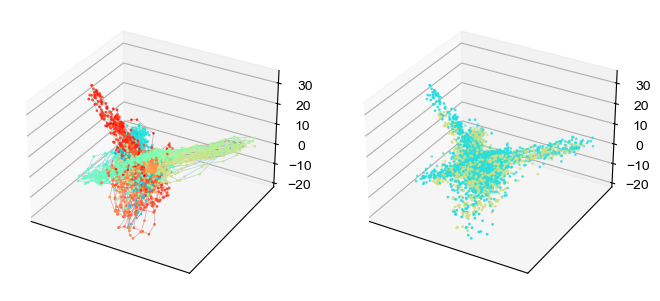

In [3]:

def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

pre_and_final_segment_bins = np.concatenate([CP_DSP[6], [97, 98, 86, 128, 140, 139, 143, 118, 119, 107, 108, 120]]) #np.concatenate([np.array([135, 134, 133, 121, 109, 110, 122, 123, 111, 112, 100]), CP_DSP[3]])

def visualize_phase_plot(reduced_data:np.ndarray, lap_traj: np.ndarray):
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]])
    effect_idx = np.concatenate([np.arange(beg[i], end[i]-1) for i in range(len(beg))])
    
    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
    
    nx = ny = 50
    
    x_norm = (reduced_data[:, 0] - x_min) / (x_max - x_min + 1e-10)
    y_norm = (reduced_data[:, 1] - y_min) / (y_max - y_min + 1e-10)
    x_binned = (x_norm // (1/nx)).astype(np.int64)
    y_binned = (y_norm // (1/ny)).astype(np.int64)
    dx = np.diff(x_norm)
    dy = np.diff(y_norm)
    
    angles_mat = np.zeros((nx, ny))
    strengths = np.zeros((nx, ny))
    for i in range(len(nx)):
        for j in range(len(ny)):
            idx = np.where((x_binned == i) & (y_binned == j))[0]
            if len(idx) == 0:
                angles_mat[i, j] = np.nan
            else:
                dx_mean = np.mean(dx[idx])
                dy_mean = np.mean(dy[idx])
                angles_mat[i, j] = np.arctan2(dy_mean, dx_mean)
                strengths[i, j] = np.sqrt(dx_mean**2 + dy_mean**2)
                
                
    # Gaussian smoothing
    from scipy.ndimage import gaussian_filter
    angles_mat = gaussian_filter(angles_mat, sigma=1)
    strengths = gaussian_filter(strengths, sigma=1)
    
    fig = plt.figure(figsize=(4, 4))
    ax = Clear_Axes(fig.add_subplot(111), close_spines=['top', 'right'])
    ax.axis([0, 1, 0, 1])
    ax.set_aspect('equal')
    #ax.imshow(strengths.T, cmap='coolwarm')
    x = np.linspace(0, 1, nx+1)
    y = np.linspace(0, 1, ny+1)
    x = (x[:-1] + x[1:]) / 2
    y = (y[:-1] + y[1:]) / 2
    X, Y = np.meshgrid(x, y)
    ax.quiver(
        X.flatten(),
        Y.flatten(),
        np.cos(angles_mat.flatten()),
        -np.sin(angles_mat.flatten()),
        strengths.flatten(),
        cmap = 'coolwarm',
        scale=5
    )
    plt.show()
    
def visualize(mouse: int):
    mouse_date = {
        10212: [3, 4, 5],
        10224: [0],
        10227: [2, 3, 4],
        10232: [0, 1]
    }
    if exists(join(loc, f"{mouse}.pkl")):
        with open(join(loc, f"{mouse}.pkl"), 'rb') as f:
            neural_traj, node_traj, pos_traj, speed_traj, lap_traj, session_traj, map_traj, route_traj, time_traj, len_traj = pickle.load(f)
        print(neural_traj.shape)
    else:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        neural_traj = []
        node_traj = []
        pos_traj = []
        speed_traj = []
        lap_traj = []
        session_traj = []
        map_traj = []
        route_traj = []
        time_traj = []
        len_traj = []
        
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
            
        is_cell = np.where(index_map == 0, 0, 1)
        cell_count = np.sum(is_cell, axis=0)
        cell_idx = np.where(cell_count == 7)[0]
        
        for session in mouse_date[mouse]:
            with open(f2['Trace File'][file_idx[session]], 'rb') as f:
                trace = pickle.load(f)
                
            with open(join(dir_name0, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)

            kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
            U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
            U = U[session_label == session, :]
            
            beg_time, end_time = trace['lap beg time'], trace['lap end time']
            beg, end = LapSplit(trace, trace['paradigm'])
            routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)    
            
            for j in tqdm(np.where(np.isin(routes, [3, 6, 1, 4]))[0]):
                spike_idx = np.where(
                    (trace['ms_time'] >= beg_time[j]) & (trace['ms_time'] <= end_time[j]) &
                    (np.isnan(trace['spike_nodes_original']) == False)
                )[0]
                init_idx = spike_idx[0]
                in_seg_idx = np.where(np.isin(spike_nodes_transform(trace['spike_nodes_original'][spike_idx], 12), pre_and_final_segment_bins))[0]
                spike_idx = spike_idx[in_seg_idx]

                spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
                Spikes = trace['Spikes_original'][:, spike_idx]
                
                spike_train = SpikeTrain(
                    activity=Spikes,
                    time=trace['ms_time'][spike_idx],
                    variable=VariableBin(spike_nodes),
                )
                neural_trajs: NeuralTrajectory = spike_train.calc_neural_trajectory(500, 100)
                spike_t = np.asarray(neural_trajs.time) / 1000
                
                x = trace['correct_pos'][beg[j]:end[j], 0]/10
                y = trace['correct_pos'][beg[j]:end[j], 1]/10
                t = trace['correct_time'][beg[j]:end[j]]/1000 - trace['correct_time'][beg[j]]/1000
                dx = np.diff(x)
                dy = np.diff(y)
                dt = np.diff(t)
                dis = np.sqrt(dx**2+dy**2)
                cumdis = np.concatenate([[0], np.cumsum(dis)])
                v = np.convolve(np.sqrt(dx**2 + dy**2), np.ones(5), mode='same') / np.convolve(dt, np.ones(5), mode='same')
                
                #spike_t = (trace['ms_time'][spike_idx] - trace['ms_time'][init_idx])/1000
                idx = _coordinate_recording_time(spike_t, t[:-1])
                
                neural_traj.append(neural_trajs.to_array()[index_map[session, cell_idx]-1, :].astype(np.float64))
                _Length = neural_traj[-1].shape[1]
                node_traj.append(neural_trajs.variable.to_array().astype(np.int64))
                pos_traj.append(np.vstack([x, y])[:, idx].astype(np.float64).T)
                speed_traj.append(v[idx].astype(np.float64))
                lap_traj.append(np.repeat(j, _Length).astype(np.int64))
                session_traj.append(np.repeat(session, _Length).astype(np.int64))
                map_traj.append(np.repeat(U[j, 1], _Length).astype(np.int64))
                route_traj.append(np.repeat(routes[j], _Length).astype(np.int64))
                time_traj.append(spike_t.astype(np.float64))
                len_traj.append(cumdis[idx].astype(np.float64))
            
        neural_traj = np.concatenate(neural_traj, axis=1)
        node_traj = np.concatenate(node_traj)
        pos_traj = np.concatenate(pos_traj, axis=0)
        speed_traj = np.concatenate(speed_traj)
        lap_traj = np.concatenate(lap_traj)
        session_traj = np.concatenate(session_traj)
        map_traj = np.concatenate(map_traj)
        route_traj = np.concatenate(route_traj)
        time_traj = np.concatenate(time_traj)
        len_traj = np.concatenate(len_traj)
        
        with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
            pickle.dump([
                neural_traj, node_traj, pos_traj, speed_traj, lap_traj, session_traj, map_traj, route_traj, time_traj, len_traj
            ], f)
        print(neural_traj.shape)
        print(join(loc, f"{mouse}.pkl"), "  is saved")
    
    D = GetDMatrices(1, 48)
    
    dist_arr = D[node_traj-1, 2303]
    colors = sns.color_palette('rainbow', as_cmap=True)(1-(dist_arr - dist_arr.min()) / (dist_arr.max() + 1e-10 - dist_arr.min()))
    map_colors = MAPPaletteRGBA[map_traj, :]
    session_colors = [sns.color_palette('rainbow', len(np.unique(session_traj)))[i] for i in session_traj - np.min(session_traj)]
    
    if exists(join(loc, f"{mouse}_isomap.pkl")):#exists(join(loc, f"{mouse}_umap.pkl")):#
        """ 
        with open(join(loc, f"{mouse}_umap.pkl"), 'rb') as f:
            reduced_data, umap_model = pickle.load(f)
        """
        with open(join(loc, f"{mouse}_isomap.pkl"), 'rb') as f:
            reduced_data, isomap_model = pickle.load(f)
        
    else:
        n_component_pca = 30
        n_component_isomap = 6
        n_neighbors = 100
        
        pca = PCA(n_components=n_component_pca)
        denoised_data = pca.fit_transform(neural_traj.T)
        """ 
        umap_model = UMAP(
            n_components=n_component_isomap, 
            n_neighbors=n_neighbors,
            metric='cosine'
        )

        print("UMAP Fitting...  ", end='')
        t1 = time.time()
        reduced_data = umap_model.fit_transform(denoised_data)
        print(f"{time.time() - t1:.3f} seconds")
        with open(join(loc, f"{mouse}_umap.pkl"), 'wb') as f:
            pickle.dump([reduced_data, umap_model], f)
        """
        t1 = time.time()
        isomap_model = Isomap(n_components=n_component_isomap, n_neighbors=n_neighbors)
        print("ISOMAP Fitting...  ", end='')
        isomap_model.fit(denoised_data)
        print(f"{time.time() - t1:.3f} seconds")
        reduced_data = np.zeros((neural_traj.shape[1], n_component_isomap))
        print("ISOMAP Transforming...")
        for i in tqdm(range(0, neural_traj.shape[1], 1000)):
            sup_idx = min(i + 1000, neural_traj.shape[1])
            reduced_data[i:sup_idx] = isomap_model.transform(denoised_data[i:sup_idx])
        
        with open(join(loc, f"{mouse}_isomap.pkl"), 'wb') as f:
            pickle.dump([reduced_data, isomap_model], f)
            
    
           
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]])
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), subplot_kw={'projection': '3d'})
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'])
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'])
    x, y, z = reduced_data[:, 2], reduced_data[:, 3], reduced_data[:, 4]
    ax0.scatter(
        x, y, z,
        c=colors, 
        s=1,
        alpha=0.8, 
        edgecolors=None
    )    
    for i in range(len(beg)):
        
        ax0.plot(
                x[beg[i]:end[i]],
                y[beg[i]:end[i]],
                z[beg[i]:end[i]],
                color=DSPPalette[route_traj[beg[i]]], 
                linewidth=0.5, 
        )
        """
        ax0.plot(
            [reduced_data[beg[i], 0]],
            [reduced_data[beg[i], 1]],
            'o',
            c='k',
            markersize=5,
            markeredgewidth=0
        )
        ax0.plot(
            [reduced_data[end[i]-1, 0]],
            [reduced_data[end[i]-1, 1]],
            '^',
            c='k',
            markersize=5,
            markeredgewidth=0
        )
        """
    ax1.scatter(
        x, y, z,
        c=session_colors, 
        s=1, 
        edgecolors=None##
    )
    plt.show()

visualize(10232)

# Population Vector Correlation over Pre-Final Segment

In [6]:
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

def get_pvc(mouse: int, session: int):
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as handle:
        trace = pickle.load(handle)

    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    
    bins = CP_DSP[6]-1
    smoothed_map = smoothed_map[:, bins, :]

    with open(join(dir_name0, f"{mouse}.pkl"), 'rb') as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    U = U[session_label == session, :]
    
    averaged_map0 = np.reshape(V[0, :], [bins.shape[0], -1])
    averaged_map3 = np.reshape(V[1, :], [bins.shape[0], -1])
    averaged_map6 = trace[f'node 6']['old_map_clear'][:, bins].T
    
    pvc_corr1 = np.zeros((routes.shape[0], bins.shape[0]))
    pvc_corr4 = np.zeros((routes.shape[0], bins.shape[0]))
    
    for i in range(routes.shape[0]):
        for j in range(bins.shape[0]):
            pvc_corr1[i, j] = np.corrcoef(
                X[i, j, :], averaged_map0[j, :]
            )[0, 1]
            
            pvc_corr4[i, j] = np.corrcoef(
                X[i, j, :], averaged_map3[j, :]
            )[0, 1]
            
    
    bin_id, route_id = np.meshgrid(np.arange(bins.shape[0]), routes)
    bin_id, lap_id = np.meshgrid(np.arange(bins.shape[0]), np.arange(routes.shape[0]))
    return pvc_corr1, route_id, bin_id, lap_id, pvc_corr4

if exists(join(figdata, f"{code_id} [PVC].pkl")) == False:
    PVCData = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'Lap': [],
        'Bin': [],
        'PVC': [],
        'PVC2': [] # With Route 4
    }
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in tqdm(range(7)):
            if mouse in [10212, 10227] and s == 1:
                continue
            
            pvc_corr, route_id, bin_id, lap_id, pvc_corr4 = get_pvc(mouse, s)
            for i in range(pvc_corr.shape[0]):
                idx = np.where(np.isnan(pvc_corr[i, :]) == False)[0]
                pvc_corr[i, idx] = np.convolve(pvc_corr[i, idx], np.ones(3)/3, mode='same')
                idx = np.where(np.isnan(pvc_corr4[i, :]) == False)[0]
                if idx.shape[0] == 0:
                    pvc_corr4[i, :] = np.nan
                else:
                    pvc_corr4[i, idx] = np.convolve(pvc_corr4[i, idx], np.ones(3)/3, mode='same')
                
            PVCData['MiceID'].append(np.repeat(mouse, pvc_corr.shape[0] * pvc_corr.shape[1]))
            PVCData['Session'].append(np.repeat(session_convertor[mouse][s], pvc_corr.shape[0] * pvc_corr.shape[1]))
            PVCData['Route'].append(route_id.flatten())
            PVCData['Lap'].append(lap_id.flatten())
            PVCData['Bin'].append(bin_id.flatten())
            PVCData['PVC'].append(pvc_corr.flatten())
            PVCData['PVC2'].append(pvc_corr4.flatten())
    
    for k in PVCData.keys():
        PVCData[k] = np.concatenate(PVCData[k])
        
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'wb') as f:
        pickle.dump(PVCData, f)
    
    PVCD = pd.DataFrame(PVCData)
    PVCD.to_excel(join(figdata, f"{code_id} [PVC].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'rb') as f:
        PVCData = pickle.load(f)

mice_color = {
    10212: 'k',
    10224: MicePaletteDSP[1],
    10227: MicePaletteDSP[2],
    10232: MicePaletteDSP[3]
}
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(4*4, 3*3))
for s in range(-5, 7):
    c, r = (s+5) % 3, (s+5) // 3
    SubData = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 6))[0])
    SubData4 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 3))[0])
    SubData0 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(np.isin(PVCData['Route'], [0, 1, 2, 4, 5]))&(PVCData['Bin'] >= 4))[0])
    
    ax = Clear_Axes(axes[c, r], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.plot([0, 4.5], [0.75, 0.75], color=DSPPalette[6], linewidth=5)
    ax.plot([4.5, 11.5], [0.75, 0.75], color='#BDC8DE', linewidth=5)
    ax.plot([11.5, CP_DSP[6].shape[0]-1], [0.75, 0.75], color=DSPPalette[3], linewidth=5)
    beg = np.concatenate([[0], np.where(np.diff(SubData['Bin']) < 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(SubData['Bin']) < 0)[0] + 1, [len(SubData['Bin'])]])
    for i in range(len(beg)):
        idx = np.where((np.isnan(SubData['PVC'][beg[i]:end[i]]) == False))[0]
        ax.plot(
            SubData['Bin'][beg[i]:end[i]][idx],
            SubData['PVC'][beg[i]:end[i]][idx],
            color= mice_color[SubData['MiceID'][beg[i]]],
            linewidth=0.5
        )
    ax.set_title(f"Session {s}")
    ax.set_ylim(-0.1, 0.8)
    ax.set_yticks(np.linspace(0, 0.8, 5))
    ax.set_xlim(0, CP_DSP[6].shape[0]-1)

plt.savefig(join(loc, "PVC with Route 1.png"), dpi=600)
plt.savefig(join(loc, "PVC with Route 1.svg"), dpi=600)
plt.close()

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(4*4, 3*3))
for s in range(-5, 7):
    c, r = (s+5) % 3, (s+5) // 3
    SubData = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 6))[0])
    SubData4 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 3))[0])
    SubData0 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(np.isin(PVCData['Route'], [0, 1, 2, 4, 5]))&(PVCData['Bin'] >= 4))[0])
    
    ax = Clear_Axes(axes[c, r], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.plot([0, 4.5], [0.75, 0.75], color=DSPPalette[6], linewidth=5)
    ax.plot([4.5, 11.5], [0.75, 0.75], color='#BDC8DE', linewidth=5)
    ax.plot([11.5, CP_DSP[6].shape[0]-1], [0.75, 0.75], color=DSPPalette[3], linewidth=5)
    beg = np.concatenate([[0], np.where(np.diff(SubData['Bin']) < 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(SubData['Bin']) < 0)[0] + 1, [len(SubData['Bin'])]])
    for i in range(len(beg)):
        idx = np.where((np.isnan(SubData['PVC2'][beg[i]:end[i]]) == False))[0]
        ax.plot(
            SubData['Bin'][beg[i]:end[i]][idx],
            SubData['PVC2'][beg[i]:end[i]][idx],
            color= mice_color[SubData['MiceID'][beg[i]]],
            linewidth=0.5
        )
    ax.set_title(f"Session {s}")
    ax.set_ylim(-0.1, 0.8)
    ax.set_yticks(np.linspace(0, 0.8, 5))
    ax.set_xlim(0, CP_DSP[6].shape[0]-1)

plt.savefig(join(loc, "PVC with Route 4.png"), dpi=600)
plt.savefig(join(loc, "PVC with Route 4.svg"), dpi=600)
plt.close()

# Correlation on Pre-Final Segment

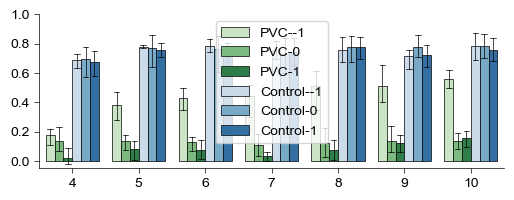

Bin 4:
  PVC: F_onewayResult(statistic=3.803501797531527, pvalue=0.06903698655863216)
  Control: F_onewayResult(statistic=0.026769180256614414, pvalue=0.9736727628050547)

Bin 5:
  PVC: F_onewayResult(statistic=12.37334540431377, pvalue=0.0035619701112965508)
  Control: F_onewayResult(statistic=0.05405024414970042, pvalue=0.947727446059345)

Bin 6:
  PVC: F_onewayResult(statistic=22.71324996225197, pvalue=0.0005027279757422254)
  Control: F_onewayResult(statistic=0.17001640307373134, pvalue=0.8466207570236755)

Bin 7:
  PVC: F_onewayResult(statistic=20.890689277709082, pvalue=0.0006669484567081974)
  Control: F_onewayResult(statistic=0.04128700275425789, pvalue=0.9597567801395289)

Bin 8:
  PVC: F_onewayResult(statistic=14.492662334049676, pvalue=0.0021889820801890268)
  Control: F_onewayResult(statistic=0.046598096714670884, pvalue=0.9547280307602898)

Bin 9:
  PVC: F_onewayResult(statistic=14.974659299916652, pvalue=0.0019748950383747937)
  Control: F_onewayResult(statistic=0.5951780

In [24]:
def get_pvc(mouse: int, session: int):
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as handle:
        trace = pickle.load(handle)

    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)

    bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[6]])-1
    
    averaged_map0 = np.mean(np.stack([
        trace[f'node {i}']['smooth_map_all'] for i in [0, 4, 5, 9]
    ], axis=2), axis=2)

    averaged_map6 = trace[f'node 8']['smooth_map_all']
    averaged_map1 = trace[f'node 1']['smooth_map_all']

    pvc_corr = np.zeros(7)
    pvc_ctrl = np.zeros(7)
    for i in range(4, 11):
        b = np.asarray(Father2SonGraph[CP_DSP[6][i]])
        pvc_corr[i-4] = np.corrcoef(averaged_map0[:, b-1].flatten(), averaged_map6[:, b-1].flatten())[0, 1]
        pvc_ctrl[i-4] = np.corrcoef(averaged_map0[:, b-1].flatten(), averaged_map1[:, b-1].flatten())[0, 1]

    return pvc_corr, np.arange(4, 11), pvc_ctrl

if exists(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl")) == False:
    CorrPFS = {
        'MiceID': [],
        'Session': [],
        'Bin': [],
        'PVC': [],
        'Type': []
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in tqdm(range(7)):
            pvc_corr, bins, pvc_ctrl = get_pvc(mouse, s)
            CorrPFS['MiceID'].append(np.repeat(mouse, len(pvc_corr)*2))
            CorrPFS['Session'].append(np.repeat(session_convertor[mouse][s], len(pvc_corr)*2))
            CorrPFS['Bin'].append(np.concatenate([bins, bins]))
            CorrPFS['PVC'].append(np.concatenate([pvc_corr, pvc_ctrl]))
            CorrPFS['Type'].append(np.concatenate([np.repeat('PVC', len(pvc_corr)), np.repeat('Control', len(pvc_ctrl))]))
    
    for k in CorrPFS.keys():
        CorrPFS[k] = np.concatenate(CorrPFS[k])
        
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl"), 'wb') as f:
        pickle.dump(CorrPFS, f)
        
    CorrPFSD = pd.DataFrame(CorrPFS)
    CorrPFSD.to_excel(join(figdata, f"{code_id} [PVC on Pre-Final Segment].xlsx"), index=False)
    print(len(CorrPFSD))
else:
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl"), 'rb') as f:
        CorrPFSD = pickle.load(f)

fig = plt.figure(figsize=(6, 2))
SubData = SubDict(CorrPFSD, CorrPFSD.keys(), np.where((np.abs(CorrPFSD['Session']) <= 1))[0])
SubData['hue'] = np.array([f"{SubData['Type'][i]}-{SubData['Session'][i]}" for i in range(len(SubData['Type']))])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.barplot(
    x=SubData['Bin'], 
    y=SubData['PVC'], 
    hue=SubData['hue'], 
    hue_order=['PVC--1', 'PVC-0', 'PVC-1', 'Control--1', 'Control-0', 'Control-1'],
    ax=ax, 
    palette=sns.color_palette("Greens", 3) + sns.color_palette("Blues", 3),
    capsize=0.5,
    edgecolor='black',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'}
)
ax.set_ylim(-0.05, 1)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "PVC on Pre-Final Segment.png"), dpi=600)
plt.savefig(join(loc, "PVC on Pre-Final Segment.svg"), dpi=600)
plt.show()

for b in range(4, 11):
    SubData = SubDict(CorrPFSD, CorrPFSD.keys(), np.where((CorrPFSD['Bin'] == b))[0])
    x0 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == -1))[0])
    x1 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == 0))[0])
    x2 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == 1))[0])
    x3 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == -1))[0])
    x4 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == 0))[0])
    x5 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == 1))[0])
    
    print(f"Bin {b}:")
    print(f"  PVC: {f_oneway(x0['PVC'], x1['PVC'], x2['PVC'])}")
    print(f"  Control: {f_oneway(x3['PVC'], x4['PVC'], x5['PVC'])}", end='\n\n')

# Cross-Day Correlation

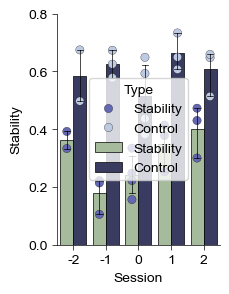

Control: F_onewayResult(statistic=1.1989121815206487, pvalue=0.36960286501514017)
Stability: F_onewayResult(statistic=4.489137633412617, pvalue=0.02466152655037741)
  Mean: 0.18048366246786948, STD: 0.05338563907755823, Max: 0.2222970765511138, Min: 0.105136451280838, Median: 0.21401745957165655, df: 2
  Mean: 0.4010416130611268, STD: 0.07339253423418224, Max: 0.47274276103067636, Min: 0.3001994614923298, Median: 0.4301826166603744, df: 2


In [47]:
if exists(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl")) == False:
    CorrPFSStab = {
        'MiceID': [],
        'Session': [],
        'Stability': [],
        'Type': []
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[6][4:11]]) - 1

    for mouse in [10212, 10224, 10227, 10232]:
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
        
        is_cell = np.where(index_map == 0, 0, 1)
        cell_count = np.sum(is_cell, axis=0)
        cell_idx = np.where(cell_count == 7)[0]
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        for s in tqdm(range(6)):
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace1 = pickle.load(f)
                
            with open(f2['Trace File'][file_idx[s+1]], 'rb') as f:
                trace2 = pickle.load(f)
            
            averaged_map6_1 = trace1[f'node 8']['smooth_map_all']
            averaged_map6_2 = trace2[f'node 8']['smooth_map_all']
            
            averaged_map1_1 = trace1[f'node 1']['smooth_map_all']
            averaged_map1_2 = trace2[f'node 1']['smooth_map_all']
            
            corr = np.corrcoef(
                averaged_map6_1[np.ix_(index_map[s, cell_idx]-1, bins)].flatten(), 
                averaged_map6_2[np.ix_(index_map[s+1, cell_idx]-1, bins)].flatten()
            )[0, 1]

            corr_ctrl = np.corrcoef(
                averaged_map1_1[np.ix_(index_map[s, cell_idx]-1, bins)].flatten(), 
                averaged_map1_2[np.ix_(index_map[s+1, cell_idx]-1, bins)].flatten()
            )[0, 1]

            CorrPFSStab['MiceID'].append(np.repeat(mouse, 2))
            CorrPFSStab['Session'].append(np.repeat(session_convertor[mouse][s], 2))
            CorrPFSStab['Stability'].append(np.array([corr, corr_ctrl]))
            CorrPFSStab['Type'].append(np.array(['Stability', 'Control']))

    for k in CorrPFSStab.keys():
        CorrPFSStab[k] = np.concatenate(CorrPFSStab[k])

    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl"), 'wb') as f:
        pickle.dump(CorrPFSStab, f)

    CorrPFSStabD = pd.DataFrame(CorrPFSStab)
    CorrPFSStabD.to_excel(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].xlsx"), index=False)
    print(len(CorrPFSStabD))
else:
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl"), 'rb') as f:
        CorrPFSStab = pickle.load(f)
        
fig = plt.figure(figsize=(2.1, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(CorrPFSStab, CorrPFSStab.keys(), np.where((np.abs(CorrPFSStab['Session']) <= 2))[0])
sns.stripplot(
    x = 'Session',
    y = 'Stability',
    data=SubData,
    hue='Type',
    palette = ['#6467b1', '#becae1'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0,
    edgecolor='k',
    ax = ax,
    zorder=2
)
sns.barplot(
    x = 'Session',
    y = 'Stability',
    data=SubData,
    hue='Type',
    palette = [RemappingPalette[1], RemappingPalette[0]],
    capsize=0.4,
    edgecolor='k',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    ax = ax,
    zorder=1
)
ax.set_ylim(0, 0.8)
ax.set_yticks(np.linspace(0, 0.8, 5))
plt.savefig(join(loc, "PVC on Pre-Final Segment, Cross-Day.png"), dpi=600)
plt.savefig(join(loc, "PVC on Pre-Final Segment, Cross-Day.svg"), dpi=600)
plt.show()

res = [SubData['Stability'][(SubData['Session'] == s)&(SubData['Type'] == 'Stability')] for s in [-2, -1, 0, 1, 2]]
res0 = [SubData['Stability'][(SubData['Session'] == s)&(SubData['Type'] == 'Control')] for s in [-2, -1, 0, 1, 2]]
print(f"Control: {f_oneway(*res0)}")
print(f"Stability: {f_oneway(*res)}")
print_estimator(res[1])
print_estimator(res[4])

# Behavioral Analysis for Map Swing of R7